In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/products/Hot_cmems_climato_2002_2014.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_HOT_climato_obs_npp_opti_all_parameters_2_groups"

In [89]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-02"
TIME_END = "2009-12-27"

## Loading


### Forcing


In [90]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 321kB
Dimensions:              (latitude: 1, longitude: 1, depth: 3, time: 1821)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables: (12/13)
    T                    (latitude, longitude, depth, time) float64 44kB 23.8...
    U                    (latitude, longitude, depth, time) float64 44kB -0.0...
    V                    (latitude, longitude, depth, time) float64 44kB -0.0...
    mnkc_epi             (latitude, longitude, time) float64 15kB 0.2892 ... ...
    mnkc_hmlmeso         (latitude, longitude, time) float64 15kB 0.822 ... 0...
    mnkc_lmeso           (latitude, longitude, time) float64 15kB 2.139 ... 2...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 15kB 0.575 ... 0...
    mnkc_umeso           (latitude, longitude, time) float64 15kB 0.5002 ... ...
    npp                  (latitude, longitude, time) float64 15kB 323.3 ... 3...
    pelagic_layer_depth  (latitude, longitude, depth, time) float64 44kB 113....
    zeu                  (latitude, longitude, time) float64 15kB 75.4 ... 75.29
    zooc                 (latitude, longitude, time) float64 15kB 0.2672 ... ...

### Epipelagic layer


In [91]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[113.10354321928514 114.18750083099961 113.81216693411004 ... 113.72807877620157 113.59442872389666 112.94051799923405]]]
Units,meter


<!-- ## Observed NPP -->


In [92]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 44kB
Dimensions:          (time: 1821, latitude: 1, longitude: 1)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * time             (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables:
    l12              (time, latitude, longitude) float64 15kB 255.4 ... 257.5
    l12_lowess_0.05  (time, latitude, longitude) float64 15kB 259.5 ... 258.8
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

### Observations


In [93]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[179.1993152851171]]] [[[207.78348092804256]]] [[[256.97140808136334]]] [[[276.73713373591653]]] [[[286.8754053335449]]] [[[289.4875232614997]]] [[[315.3292764814672]]] [[[297.1327451472592]]] [[[252.05575513504192]]] [[[201.0579558457]]] [[[167.88955162294909]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]]]
Units,milligram/meter2
Magnitude,[[[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[183.22544878939186]]] [[[209.67444462420926]]] [[[249.67832901663408]]] [[[276.32712590507947]]] [[[288.4152516159477]]] [[[290.87610485890576]]] [[[309.7226737506274]]] [[[284.86368409190277]]] [[[250.8354669340342]]] [[[205.83324959699155]]] [[[169.5300410029905]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]]]
Units,milligram/meter2
Magnitude,[[[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[310.5038532805829]]] [[[339.1815897155657]]] [[[417.05656045622504]]] [[[416.24639799937876]]] [[[428.83910602723876]]] [[[450.344131523354

Select the kind of observation you want to use.


In [94]:
# observations_selected = observations[["day_lowess_0.2", "night_lowess_0.2"]].rename(
#     {"day_lowess_0.2": "day", "night_lowess_0.2": "night"}
# )

observations_selected = observations[["day", "night"]]

Remove the 6 first months to let the model reach the stationary state.


In [95]:
observations_selected = observations_selected.isel(time=slice(6, None))
observations_selected

Magnitude,[[[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[179.1993152851171]]] [[[207.78348092804256]]] [[[256.97140808136334]]] [[[276.73713373591653]]] [[[286.8754053335449]]] [[[289.4875232614997]]] [[[315.3292764814672]]] [[[297.1327451472592]]] [[[252.05575513504192]]] [[[201.0579558457]]] [[[167.88955162294909]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]]]
Units,milligram/meter2
Magnitude,[[[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[310.5038532805829]]] [[[339.1815897155657]]] [[[417.05656045622504]]] [[[416.24639799937876]]] [[[428.83910602723876]]] [[[450.3441315233542]]] [[[452.38484638704267]]] [[[411.10336607721837]]] [[[403.9301941931383]]] [[[354.5911867290542]]] [[[285.0364859453825]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [96]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=observed_npp["l12"], resolution=1 / 12, timestep=1),
)

2025-01-23 15:14:59,189 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [97]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D2N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D2N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [98]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations_selected)],
)

Set the genetic algorithm meta parameters.


In [99]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.15,
    INDPB=0.1,
    ETA=5,
    CXPB=0.7,
    NGEN=15,
    POP_SIZE=700,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [100]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [15]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [16]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65412,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:65425,Total threads: 3
Dashboard: http://127.0.0.1:65427/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:65415,


## Run the optimization


In [17]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,104.569303,313.309664,0.004846,3054.174992,700,0.000000
1,11.138635,90.747081,0.004846,1996.154412,700,0.250000
2,1.123642,14.341913,0.002268,339.695392,700,0.304286
3,0.713958,4.887899,0.002455,97.711217,700,0.275714
4,0.413189,3.081088,0.002246,59.509925,700,0.255714
5,0.740633,7.582547,0.002492,148.351298,700,0.222857
6,0.382882,1.836729,0.002239,26.675734,700,0.207143
7,0.534283,6.498946,0.002285,165.698442,700,0.237143
8,0.965179,12.659305,0.001965,291.674641,700,0.280000


Generations: 100%|██████████| 15/15 [14:47<00:00, 59.13s/it]


## Plot the results


In [18]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,104.569303,313.309664,0.004846,3054.174992,700,0.000000
1,11.138635,90.747081,0.004846,1996.154412,700,0.250000
2,1.123642,14.341913,0.002268,339.695392,700,0.304286
3,0.713958,4.887899,0.002455,97.711217,700,0.275714
4,0.413189,3.081088,0.002246,59.509925,700,0.255714
5,0.740633,7.582547,0.002492,148.351298,700,0.222857
6,0.382882,1.836729,0.002239,26.675734,700,0.207143
7,0.534283,6.498946,0.002285,165.698442,700,0.237143
8,0.965179,12.659305,0.001965,291.674641,700,0.280000


In [19]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
13         111                        0.369068    30.605909     -0.001822   
14         475                        0.369068    30.605909     -0.001822   
12         397                        0.369068    30.605909     -0.001822   
           630                        0.369068    30.605909     -0.001822   
           286                        0.044909    45.590441     -0.040746   
...                                        ...          ...           ...   
0          183                        0.168011    24.426966     -0.014753   
           276                        0.348982     9.465244     -0.077975   
           668                        0.399154     6.469654     -0.188266   
           21                         0.392151    23.311548     -0.217111   
           179                        0.393867    28.847518     -0.265093   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
13         111                   13.874193             -0.098964   
14         475                   13.874193             -0.098964   
12         397                   13.874193             -0.098964   
           630                   13.874193             -0.098964   
           286                   31.374391             -0.034611   
...                                    ...                   ...   
0          183                  469.877013             -0.088248   
           276                  342.047740             -0.029426   
           668                  267.299908             -0.001287   
           21                   439.818868             -0.030798   
           179                  484.321416             -0.018286   

                       D2N1_energy_coefficient  D2N1_tr_max  D2N1_tr_rate  \
generation individual                                                       
13         111                        0.354581    34.939051     -0.112243   
14         475                        0.354581    34.939051     -0.225855   
12         397                        0.331164    49.248786     -0.225855   
           630                        0.281296    48.638984     -0.023566   
           286                        0.354581    49.248786     -0.207398   
...                                        ...          ...           ...   
0          183                        0.390816    44.346691     -0.087987   
           276                        0.358350    40.446378     -0.022598   
           668                        0.345018    18.077793     -0.015664   
           21                         0.279142    12.579628     -0.201307   
           179                        0.051622    43.421800     -0.020294   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate      fitness  
generation individual                                                          
13         111                   28.522970             -0.293840     0.001325  
14         475                   29.806073             -0.250683     0.001380  
12         397                   40.630997             -0.297247     0.001513  
           630                   34.973317             -0.201547     0.001548  
           286                   40.630997             -0.250683     0.001649  
...                                    ...                   ...          ...  
0          183                  433.725409             -0.007112  2192.728825  
           276                  495.044356             -0.040426  2407.651751  
           668                  365.447941             -0.090642  2656.507524  
           21                   494.204140             -0.048163  2671.841509  
           179                  312.369565             -0.037509  3054.174992  

[8049 rows x 11 columns]

In [20]:
viewer.fitness_evolution()

In [21]:
viewer.box_plot(3, nbest=1000)

In [22]:
viewer.parallel_coordinates(1000, unselected_opacity=0)

# Generate plots at each station


## Run simulation with original parameters


In [33]:
original_config = [[0, 0, 0.1668, 10.38, -0.11, 150, -0.15]]
print(f"Original configuration: {list(original_config[0])}")

Original configuration: [0, 0, 0.1668, 10.38, -0.11, 150, -0.15]


In [34]:
original_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=original_config, groups_name=["Total"]),
)

original_model.run()

## Run simulation with optimized parameters


In [115]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")
print(f"Best individual: {list(best_individual[1])}")

Best individual: [0.0, 0.0, 0.3690680794234459, 30.605909142741737, -0.0018215729496597333, 13.874192931636609, -0.09896441680610593]
Best individual: [1.0, 0.0, 0.3545812788255186, 34.93905106023773, -0.11224260655142415, 28.522969628456462, -0.293840272383768]


In [116]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1", "D2N1"]),
)

model_print.run()

In [129]:
fig = px.line(
    model_print.export_biomass().pint.quantify().pint.to("mg/m2").to_dataframe().reset_index(),
    x="time",
    y="biomass",
    color="functional_group",
    title="Biomass over Time : Daily",
)

fig.add_trace(
    go.Scatter(
        x=observed_npp.l12.time.data.flatten(),
        y=observed_npp.l12.pint.quantify().pint.to("mg/m2/day").data.flatten(),
        mode="lines",
        name="Primary Production",
        yaxis="y2",
    )
)
fig.add_trace(
    go.Scatter(
        x=observations.day.time.data.flatten(),
        y=observations.day.pint.quantify().pint.to("mg/m2").data.flatten(),
        mode="lines",
        name="Observations day",
    )
)
fig.add_trace(
    go.Scatter(
        x=observations.night.time.data.flatten(),
        y=observations.night.pint.quantify().pint.to("mg/m2").data.flatten(),
        mode="lines",
        name="Observations night",
    )
)

fig.update_layout(yaxis2=dict(title="Primary Production (mg/m2/day)", overlaying="y", side="right"))
# Je veux plus d'espace entre la figure et la légende
fig.update_layout(legend=dict(y=1.0, x=1.1))

fig.show()

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:363: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:201: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:129: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



In [ ]:
import numpy as np

NB_INDIVIDUAL_TO_SHOW = 5

min_biomass = model_print.export_biomass().data.flatten()
max_biomass = model_print.export_biomass().data.flatten()


for cpt in range(1, NB_INDIVIDUAL_TO_SHOW):
    individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[cpt])
    model = wrapper.model_generator_no_transport(
        forcing_parameters=forcing_parameters,
        fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=individual, groups_name=["D1N1", "D2N1"]),
    )
    model.run()
    min_biomass = np.min([model.export_biomass().data.flatten(), min_biomass], axis=0)
    max_biomass = np.max([model.export_biomass().data.flatten(), max_biomass], axis=0)

In [65]:
x = list(model_print.export_biomass().time)
x_rev = list(x[::-1])

# Line 2
y = list(model_print.export_biomass().data.flatten())
y_upper = list(max_biomass)
y_lower = list(min_biomass)
y_lower = list(y_lower[::-1])


fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=x + x_rev,
        y=y_upper + y_lower,
        fill="toself",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Biomass",
    )
)

# fig.add_trace(
#     go.Scatter(
#         x=x,
#         y=y,
#         line_color="rgb(0,176,246)",
#         name="Premium",
#     )
# )


fig.update_traces(mode="lines")
fig.show()

## Plot


### Taylor Diagram


Convert to pandas series.


In [37]:
optimized_biomass_pandas = (
    model_print.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    original_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [38]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = optimized_biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [48]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        mode="lines",
        line={"color": "red", "width": 1, "dash": "dash"},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions D1N1",
    )
)
fig.add_trace(
    go.Scatter(
        x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
        y=(monthly_pred_d1n1 + monthly_pred_d2n1),
        fill=None,
        mode="lines",
        line={"color": "black", "dash": "dash"},
        name="Predictions D2N1",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_pred_orignal.index,
        y=monthly_pred_orignal,
        fill=None,
        mode="lines",
        line={"color": "blue"},
        name="Predictions Original",
    )
)

fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dot"},
)
fig.update_layout(
    yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"},
    height=600,
)

fig.show()

In [51]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_rev = x[::-1]

# Line 2
y2 = [5, 2.5, 5, 7.5, 5, 2.5, 7.5, 4.5, 5.5, 5]
y2_upper = [5.5, 3, 5.5, 8, 6, 3, 8, 5, 6, 5.5]
y2_lower = [4.5, 2, 4.4, 7, 4, 2, 7, 4, 5, 4.75]
y2_lower = y2_lower[::-1]


fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=x + x_rev,
        y=y2_upper + y2_lower,
        fill="toself",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Premium",
        showlegend=False,
    )
)

# fig.add_trace(
#     go.Scatter(
#         x=x,
#         y=y2,
#         line_color="rgb(0,176,246)",
#         name="Premium",
#     )
# )


fig.update_traces(mode="lines")
fig.show()

In [30]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [0.8538636130405541, 0.9248188608974913, 0.7795200798858419, 0.799761974393508]
norm STD [0.960882987416807, 1.150895587233063, 1.1130114430829408, 0.9381850367207577]
bias [0.03745222322489539, -0.14457856645058073, 0.8049727859303322, -1.5434647807794875]
NRMSE [0.5313850551316016, 0.4425163959887532, 0.7096230931852694, 0.6160695808902203]
name ['HOT Day', 'HOT Night', 'Original Day', 'Original Night']


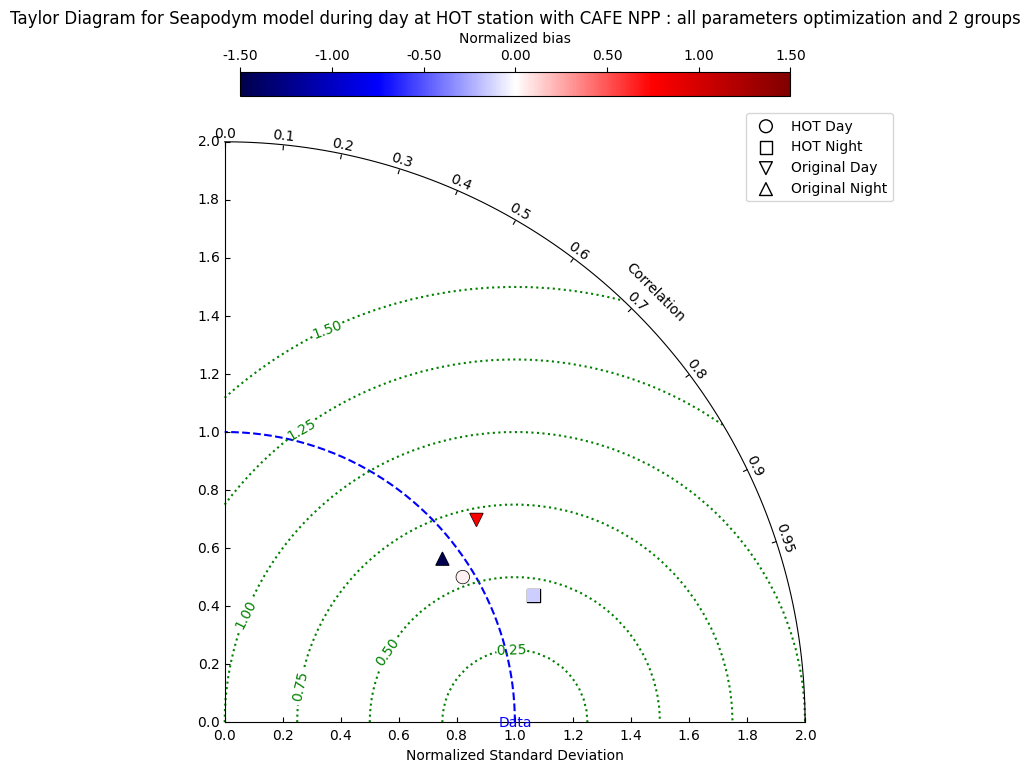

In [31]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1, monthly_pred_orignal, monthly_pred_orignal]
all_obs = [monthly_obs_day, monthly_obs_night, monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night", "Original Day", "Original Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [32]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.853864,0.960883,0.037452,0.531385
1,HOT Night,0.924819,1.150896,-0.144579,0.442516
2,Original Day,0.779520,1.113011,0.804973,0.709623
3,Original Night,0.799762,0.938185,-1.543465,0.616070
